# Natural Language Processing

## Part 4: TorchText + Padded + CNN

In the same way that a 3x3 filter can look over a patch of an image, a 1x2 filter can look over a 2 sequential words in a piece of text, i.e. a bi-gram. In this part 4, we will use multiple filters of different sizes which will look at the bi-grams (a 1x2 filter), tri-grams (a 1x3 filter) and/or n-grams (a 1x$n$ filter) within the text.

The intuition here is that the appearance of certain bi-grams, tri-grams and n-grams within the text will be a good indication of the news group.

In [1]:
import torch, torchdata, torchtext
from torch import nn

import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [2]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [3]:
torch.__version__

'1.13.0+cu117'

In [4]:
torchtext.__version__

'0.14.0'

## 1. ETL: Loading the dataset

In [5]:
#uncomment this if you are not using our department puffer
import os
os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import AG_NEWS
train, test = AG_NEWS()

In [6]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
train

ShardingFilterIterDataPipe

## 2. EDA - simple investigation

In [7]:
#let's take a look at one example of train
next(iter(train))

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [8]:
#let's change the unique label
set([y for y, x in list(iter(train))])
#{“World”, “Sports”, “Business”, “Sci/Tech”}

{1, 2, 3, 4}

In [9]:
train_size = len(list(iter(train)))
train_size

120000

Since 120000 gonna just take up too much of our GPU, and also for the sake of learning, we gonna resize it.....  All `DataPipe` instance has a handy function called `random_split`

In [10]:
too_much, train, valid = train.random_split(total_length=train_size, weights = {"too_much": 0.7, "smaller_train": 0.2, "valid": 0.1}, seed=999)

In [11]:
train_size = len(list(iter(train)))
train_size

24000

In [12]:
val_size = len(list(iter(valid)))
val_size

12000

In [13]:
test_size = len(list(iter(test)))
test_size

7600

## 3. Preprocessing 

### Tokenizing

The first step is to decide which tokenizer we want to use, which depicts how we split our sentences.

In [14]:
#pip install spacy
#python3 -m spacy download en_core_web_sm
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens = tokenizer("We are learning torchtext in AIT!")  #some test
tokens

['We', 'are', 'learning', 'torchtext', 'in', 'AIT', '!']

### Text to integers (numeral)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [15]:
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [16]:
#see some example
vocab(['here', 'is', 'a', 'unknownword', 'a'])

[509, 27, 9, 0, 9]

In [17]:
#we can reverse it....
mapping = vocab.get_itos()

#print 159, for example
mapping[509]

'here'

In [18]:
#let's try unknown vocab
vocab(['dddd', 'aaaa'])
#they will all map to <unk> which has 0 as integer

[0, 0]

In [19]:
#let's try special symbols
vocab(['<pad>', '<bos>', '<eos>'])

[1, 2, 3]

In [20]:
#so we can 50k+ unique vocabularies!
len(vocab)

52828

## 4. FastText Embeddings

In [21]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple') #small for easy training

In [22]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)
# vocab.get_itos() returns a list of strings (tokens), where the token at the i'th position is what you get from doing vocab[token]
# get_vecs_by_tokens gets the pre-trained vector for each string when given a list of strings
# therefore pretrained_embedding is a fully "aligned" embedding matrix

In [23]:
fast_embedding.shape   #we have X vocabs, each with a 300 fasttext embedding

torch.Size([52828, 300])

## 4. Preparing the dataloader

In torchtext, first thing before the batch iterator is to define how you want to process your text and label.  

In [24]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1 #turn {1, 2, 3, 4} to {0, 1, 2, 3} for pytorch training 

Let's look at example how it looks

In [25]:
text_pipeline("I love to play football")

[275, 4021, 8, 389, 574]

In [26]:
label_pipeline('1')

0

Next, let's make the batch iterator.  Here we create a function <code>collate_fn</code> that define how we want to create our batch.  **Since we are using CNN, we don't need the padded_sequence.  CNN is quite good in knowing that the padding is not useful.**

In [27]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>'] #++<----making sure our embedding layer ignores pad

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True)

Create train, val, and test dataloaders

In [28]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

Let's test the train loader.  Note that {“World”, “Sports”, “Business”, “Sci/Tech”} maps to {0, 1, 2, 3}

In [29]:
for label, text in train_loader:
    break

In [30]:
print("Label shape: ", label.shape) # (batch_size, )
print("Text shape: ", text.shape)   # (batch_size, seq len)

Label shape:  torch.Size([64])
Text shape:  torch.Size([64, 138])


## 5. Design the model

The first major hurdle is visualizing how CNNs are used for text. Images are typically 2 dimensional (we'll ignore the fact that there is a third "colour" dimension for now) whereas text is 1 dimensional. 

Consider the 2 dimensional representation of the embedded sentence below:

<img src = "figures/sentiment9.png">

We can then use a filter that is **[n x emb_dim]**. This will cover $n$ sequential words entirely, as their width will be `emb_dim` dimensions. 

Consider the image below, with our word vectors are represented in green. Here we have 4 words with 5 dimensional embeddings, creating a **[4x5]** "image" tensor. A filter that covers two words at a time (i.e. bi-grams) will be **[2x5]** filter, shown in yellow, and each element of the filter with have a _weight_ associated with it. 

The output of this filter (shown in red) will be a single real number that is the weighted sum of all elements covered by the filter.

<img src = "figures/sentiment12_2.png" width=500>

The filter then moves "down" the image (or across the sentence) to cover the next bi-gram and another output (weighted sum) is calculated. 

<img src = "figures/sentiment13.png">

Finally, the filter moves down again and the final output for this filter is calculated.

<img src = "figures/sentiment14.png">

In our case , our output will be a vector with number of elements equal to the height of the image (or length of the word) minus the height of the filter plus one, $4-2+1=3$ in this case.

In our model, we will also have different sizes of filters, heights of 3, 4 and 5, with 100 of each of them. The intuition is that we will be looking for the occurence of different tri-grams, 4-grams and 5-grams that are relevant for classification.

The next step in our model is to use *pooling* (specifically *max pooling*) on the output of the convolutional layers. Below an example of taking the maximum value (0.9) from the output of the convolutional layer on the example sentence (not shown is the activation function applied to the output of the convolutions).

<img src = "figures/sentiment15.png">

The idea here is that the maximum value is the "most important" feature for prediction, which corresponds to the "most important" n-gram within the text. How do we know what the "most important" n-gram is? Luckily, we don't have to! Through backpropagation, the weights of the filters are changed so that whenever certain n-grams that are highly indicative of the labels, the output of the filter is a "high" value. This "high" value then passes through the max pooling layer if it is the maximum value in the output. 

Note: Another nice feature of the pooling layers is that they handle sentences of different lengths. The size of the output of the convolutional layer is dependent on the size of the input to it, and different batches contain sentences of different lengths. Without the max pooling layer the input to our linear layer would depend on the size of the input sentence (not what we want). One option to rectify this would be to trim/pad all sentences to the same length, however with the max pooling layer we always know the input to the linear layer will be the total number of filters.

As our model has 100 filters of 3 different sizes, that means we have 300 different n-grams the model thinks are important. We concatenate these together into a single vector and pass them through a linear layer to predict the sentiment. We can think of the weights of this linear layer as "weighting up the evidence" from each of the 300 n-grams and making a final decision. 

### Implementation Details

We implement the convolutional layers with `nn.Conv2d`. The `in_channels` argument is the number of "channels" in your image going into the convolutional layer. In actual images this is usually 3 (one channel for each of the red, blue and green channels), however when using text we only have a single channel, the text itself. The `out_channels` is the number of filters and the `kernel_size` is the size of the filters. Each of our `kernel_size`s is going to be **[n x emb_dim]** where $n$ is the size of the n-grams.

The second dimension of the input into a `nn.Conv2d` layer must be the channel dimension. As text technically does not have a channel dimension, we `unsqueeze` our tensor to create one. This matches with our `in_channels=1` in the initialization of our convolutional layers. 

We then pass the tensors through the convolutional and pooling layers, using the `ReLU` activation function after the convolutional layers. **Note**: there an exception to this if your sentence(s) are shorter than the largest filter used. You will then have to pad your sentences to the length of the largest filter. In our dataset there are no text smaller than 5 words long so we don't have to worry about that, but you will if you are using your own data.

Finally, we perform dropout on the concatenated filter outputs and then pass them through a linear layer to make our predictions.

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):
        
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx = pad_idx)
        
        self.conv_0 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[0], emb_dim))
        self.conv_1 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[1], emb_dim))
        self.conv_2 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes[2], emb_dim))
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, seq len]
        embedded = self.embedding(text)
                
        #embedded = [batch size, seq len, emb dim]
        embedded = embedded.unsqueeze(1)  #<----make text as 1 dimensional data for Conv2d
        #embedded = [batch size, 1, seq len, emb dim]
        
        #squeeze 3 because maxpool1d expect only three dimen tensor
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3)) #conved_0 = [batch_size, n_filters,  seq len - filter_sizes[n] + 1]
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3)) #conved_1 = [batch_size, n_filters,  seq len - filter_sizes[n] + 1]
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3)) #conved_2 = [batch_size, n_filters,  seq len - filter_sizes[n] + 1]
        #conved_n = [batch size, n_filters, seq len - filter_sizes[n] + 1]
        
        #conv0_embedded_squeezed.shape[2] because we want to take max out from the whole weighted sum array
        #we squeeze 2 for linear layer
        
        #F.max_pool1d(input, kernel_size) => [batch_size, n_filters, 1]
        # After squeeze(2) => [batch_size, n_filters]
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

### Let's see how each layer works

In [32]:
batch_size, seq_len = 64, 456
input_dim  = len(vocab)

input_test = torch.randint(1, input_dim, (batch_size, seq_len))

In [33]:
input_test.shape

torch.Size([64, 456])

In [34]:
embed = nn.Embedding(input_dim, 300)

In [35]:
embedded = embed(input_test)

In [36]:
embedded.shape #(N, L, channel)

torch.Size([64, 456, 300])

In [37]:
n_filters    = 100
filter_sizes = [3, 4, 5]
emb_dim      = 300

conv_0 = nn.Conv2d(in_channels = 1, out_channels = n_filters, 
                                kernel_size = (filter_sizes[0], emb_dim))

In [38]:
embedded = embedded.unsqueeze(1)

In [39]:
embedded.shape

torch.Size([64, 1, 456, 300])

In [40]:
conv0_embedded = conv_0(embedded)

In [41]:
conv0_embedded.shape  #the last dim is 1 because it is the weighted sum

torch.Size([64, 100, 454, 1])

In [42]:
conv0_embedded_squeezed = conv0_embedded.squeeze(3)

In [43]:
conv0_embedded_squeezed.shape

torch.Size([64, 100, 454])

In [44]:
pooled = F.max_pool1d(conv0_embedded_squeezed, conv0_embedded_squeezed.shape[2])

In [45]:
pooled.shape

torch.Size([64, 100, 1])

In [46]:
pooled.squeeze(2).shape

torch.Size([64, 100])

Currently the `CNN` model can only use 3 different sized filters, but we can actually improve the code of our model to make it more generic and take any number of filters.

We do this by placing all of our convolutional layers in a  `nn.ModuleList`, a function used to hold a list of PyTorch `nn.Module`s. If we simply used a standard Python list, the modules within the list cannot be "seen" by any modules outside the list which will cause us some errors.

We can now pass an arbitrary sized list of filter sizes and the list comprehension will create a convolutional layer for each of them. Then, in the `forward` method we iterate through the list applying each convolutional layer to get a list of convolutional outputs, which we also feed through the max pooling in a list comprehension before concatenating together and passing through the dropout and linear layers.

In [47]:
class CNN(nn.Module): #more elegant version
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):
        
        super().__init__()
                
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, emb_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        embedded = self.embedding(text)
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

We can also implement the above model using 1-dimensional convolutional layers, where the embedding dimension is the "depth" of the filter and the number of tokens in the sentence is the width.

<img src = "figures/conv1d.png">

We'll run our tests in this notebook using the 2-dimensional convolutional model, but leave the implementation for the 1-dimensional model below for anyone interested. 

In [48]:
class CNN1d(nn.Module):
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):
        
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = emb_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        #text = [batch size, sent len]
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.permute(0, 2, 1)
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

## 6. Training

In [49]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) 

In [50]:
w = torch.empty(3, 5)
nn.init.kaiming_normal_(w)

tensor([[ 0.3513,  1.0135,  0.4421,  0.6361, -0.4714],
        [ 0.1078, -0.4170, -0.1532,  0.4345, -0.9875],
        [-0.0856,  1.8627, -0.1393, -0.7121, -0.0525]])

In [51]:
input_dim  = len(vocab)
emb_dim    = 300
output_dim = 4 #four classes

#for cnn
dropout = 0.5
n_filters = 100
filter_sizes = [3, 4, 5]

model = CNN(input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [52]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

15848400
 90000
   100
120000
   100
150000
   100
  1200
     4
______
16209904


As you can see, a lot of the complexity resides in the embedding layer.  In the future, we shall use some pretrained embeddings to fix this complexity.

In [53]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [54]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [55]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [56]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

### Putting everything together

In [57]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [58]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [59]:
best_valid_loss = float('inf')
num_epochs      = 5

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 0m 12s
	Train Loss: 1.554 | Train Acc: 27.20%
	 Val. Loss: 1.328 |  Val. Acc: 38.01%
Epoch: 02 | Time: 0m 10s
	Train Loss: 1.480 | Train Acc: 30.07%
	 Val. Loss: 1.275 |  Val. Acc: 47.56%
Epoch: 03 | Time: 0m 10s
	Train Loss: 1.423 | Train Acc: 32.87%
	 Val. Loss: 1.225 |  Val. Acc: 56.68%
Epoch: 04 | Time: 0m 10s
	Train Loss: 1.360 | Train Acc: 36.48%
	 Val. Loss: 1.183 |  Val. Acc: 62.63%
Epoch: 05 | Time: 0m 9s
	Train Loss: 1.315 | Train Acc: 39.05%
	 Val. Loss: 1.142 |  Val. Acc: 66.61%


Text(0, 0.5, 'loss')

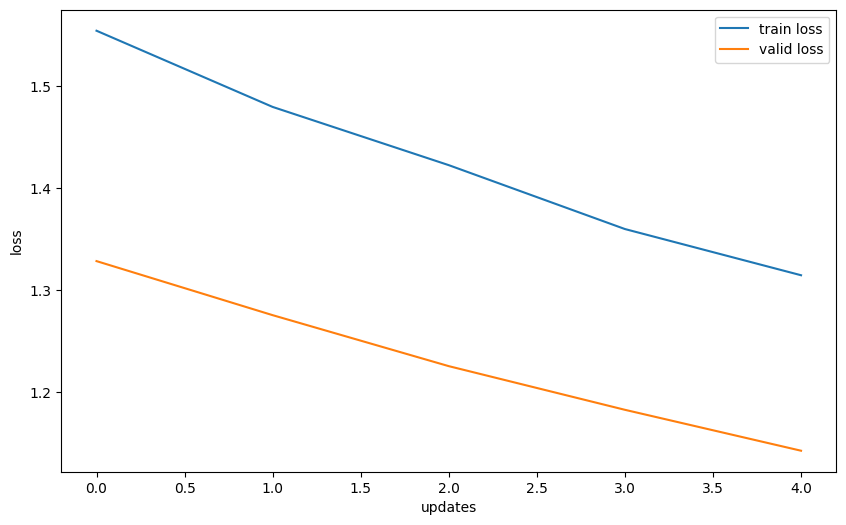

In [60]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

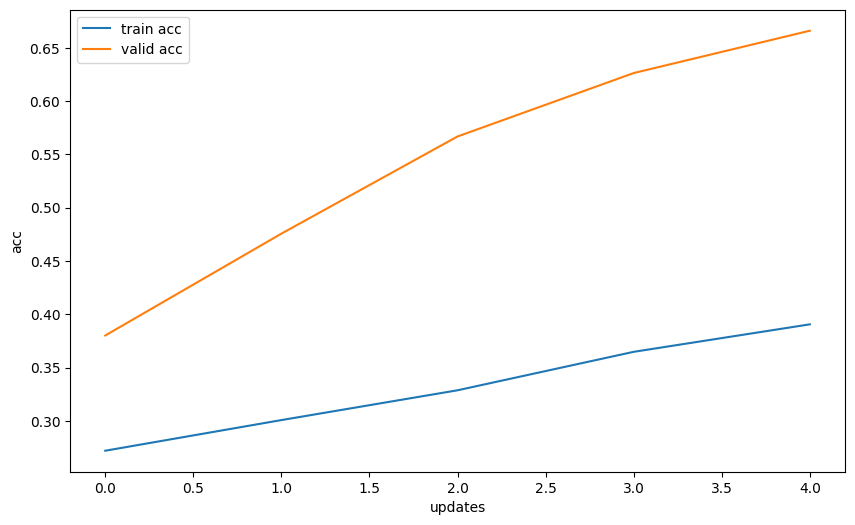

In [61]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [62]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.143 | Test Acc: 66.42%


## 7. Test on some random news

In [63]:
test_str = "Google is now falling nonstop.  The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([  190,    27,   231,  1742, 14918,     6,    16,    21,   358,    27,
         2561,  1316,   231,     6], device='cuda:0')

In [64]:
text_list = [x.item() for x in text]
text_list

[190, 27, 231, 1742, 14918, 6, 16, 21, 358, 27, 2561, 1316, 231, 6]

In [65]:
[mapping[num] for num in text_list]

['Google',
 'is',
 'now',
 'falling',
 'nonstop',
 '.',
 ' ',
 'The',
 'price',
 'is',
 'really',
 'bad',
 'now',
 '.']

In [66]:
text = text.reshape(1, -1)  #because batch_size is 1

In [67]:
text.shape

torch.Size([1, 14])

In [68]:
def predict(text):
    with torch.no_grad():
        output = model(text).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [69]:
predict(text)

tensor([2], device='cuda:0')

## Conclusion

### Practice

- Try to use the conv1d and see whether it works
- Try to add more filter and see whether you can get the code right

### Checking your understandings:

1. In Conv2d, what is the input channel for text?
     - 1
2. In Conv2d, what does the kernel size width and height represents?
     - width = embed-size, height = gram
3. Why do we want to maxpool after convolution?
    - to get the most important feature (most important gram) <===THIS IS NOT THE BEST WAY OR WORST WAY
4. Chaky said something about maxpooling help deal with different seq len, what does it mean?
    - So the dimension with seq_len become 1, that is, squeeze into 1 number
5. Let embedded.shape = (64, 10, 300), where 64 is batch size, 10 is seq len, and 300 is embed size.  The first thing I have to think before using convolution is making sure conv2d knows that my data has 1 channel.  What operation to do?
    - embedded.unsqueeze(1). ==> (64, 1, 10, 300)
6. Let say reshaped_embedded.shape = (64, 1, 10, 300).  Also let's say nn.conv2d(input channel = 1, output_channel = 100, kernel_size = (? , ?)).  What should be ?, ?
    - ?=height=gram    ?=width=300 
7. Let say reshaped_embedded.shape = (64, 1, 10, 300).  Also let's say nn.conv2d(input channel = 1, output_channel = 100, kernel_size = (3 , 300)).  What will be the output shape?
    - (64, 100, 8, 300)
    - (64, 100, 298)
    - (64, 100, 8, 1) <=====
        -  second dimension - 1 -> 100 (input channel -> output channel)
        - third dimension - use the formula
        - fourth dimension - 1 <===== one number
   '''
   number of elements equal to the height of the image (or length of the word) minus the height of the filter plus one, 10 - 3 + 1 = 8          

   '''
   
8. Lastly, chaky said something about Conv2d is related to n-grams, what does he mean?
    - so if you are using kernel_size of height 2, you are analyzing the co-occurences of two contiguous words, and if height is 3, you are analyzing tri-grams, and so on.
    - apply many filters of different sizes
    - for each size, how many filters? ==> my program up there uses 100
        - i am using 100 different filters to understand trigram, and another 100 filters to understand quadgram
        - Why 100?  Not just 1?  The idea is simple - you allow the program to focus on different relationship in different grams.  For example in tri-grams, there is a relationship between the first and the second, second and third, first and third